In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time

import healpy as hp
import pandas as pd
from sklearn.neighbors import KDTree

In [2]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

## Read in data

In [3]:
tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
print('Total number of Gaia quasars:', len(tab_gaia))

Total number of Gaia quasars: 6649162


In [4]:
tab_gaia.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','astrometric_excess_noise','visibility_periods_used','ipd_frac_multi_peak','ruwe','phot_g_n_obs','phot_g_mean_flux','phot_g_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_rp_excess_factor','in_qso_candidates','gaia_crf_source','vari_best_class_name','vari_best_class_score','fractional_variability_g','qso_variability','non_qso_variability','vari_agn_membership_score','classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classlabel_dsc','classlabel_dsc_joint','classlabel_oa','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','n_transits','intensity_quasar','intensity_quasar_error','host_galaxy_detected','intensity_hostgalaxy','intensity_hostgalaxy_error','radius_hostgalaxy','radius_hostgalaxy_error','host_galaxy_flag','source_selection_flags','allwise_oid','designation','w1mpro','w2mpro','

In [5]:
tab_sdss = Table.read('../data/SDSS_DR16Q_v4.fits', format='fits') 
print('Total number of SDSS quasars:', len(tab_sdss))

Total number of SDSS quasars: 750414


In [6]:
tab_sdss.columns

<TableColumns names=('SDSS_NAME','RA','DEC','PLATE','MJD','FIBERID','AUTOCLASS_PQN','AUTOCLASS_DR14Q','IS_QSO_QN','Z_QN','RANDOM_SELECT','Z_10K','Z_CONF_10K','PIPE_CORR_10K','IS_QSO_10K','THING_ID','Z_VI','Z_CONF','CLASS_PERSON','Z_DR12Q','IS_QSO_DR12Q','Z_DR7Q_SCH','IS_QSO_DR7Q','Z_DR6Q_HW','Z_DR7Q_HW','IS_QSO_FINAL','Z','SOURCE_Z','Z_PIPE','ZWARNING','OBJID','Z_PCA','ZWARN_PCA','DELTACHI2_PCA','Z_HALPHA','ZWARN_HALPHA','DELTACHI2_HALPHA','Z_HBETA','ZWARN_HBETA','DELTACHI2_HBETA','Z_MGII','ZWARN_MGII','DELTACHI2_MGII','Z_CIII','ZWARN_CIII','DELTACHI2_CIII','Z_CIV','ZWARN_CIV','DELTACHI2_CIV','Z_LYA','ZWARN_LYA','DELTACHI2_LYA','Z_LYAWG','Z_DLA','NHI_DLA','CONF_DLA','BAL_PROB','BI_CIV','ERR_BI_CIV','AI_CIV','ERR_AI_CIV','BI_SIIV','ERR_BI_SIIV','AI_SIIV','ERR_AI_SIIV','BOSS_TARGET1','EBOSS_TARGET0','EBOSS_TARGET1','EBOSS_TARGET2','ANCILLARY_TARGET1','ANCILLARY_TARGET2','NSPEC_SDSS','NSPEC_BOSS','NSPEC','PLATE_DUPLICATE','MJD_DUPLICATE','FIBERID_DUPLICATE','SPECTRO_DUPLICATE','SKYVERSION

Include only SDSS quasars with z>0.01 (this removes zeros and nans, and maybe a few others)

In [7]:
z_min = 0.01
idx_sdssgood = tab_sdss['Z'] > z_min
tab_sdss = tab_sdss[idx_sdssgood]
print(f'Number of SDSS quasars with: z > {z_min}: {len(tab_sdss)}')

Number of SDSS quasars with: z > 0.01: 750397


Cross-match SDSS and Gaia

First two return values of search_around_sky:

idx1: Indices into coords1 that matches to the corresponding element of idx2. Shape matches idx2.

idx2:Indices into coords2 that matches to the corresponding element of idx1. Shape matches idx1

In [8]:
coords_sdss = SkyCoord(ra=tab_sdss['RA']*u.degree, dec=tab_sdss['DEC']*u.degree, frame='icrs')    
coords_gaia = SkyCoord(ra=tab_gaia['ra'], dec=tab_gaia['dec'], frame='icrs') 
cross_sdss_gaia = coords_gaia.search_around_sky(coords_sdss, 1*u.arcsec) # Hogg thinks this is idiotic

Make new table, tab_xmatch, with only gaia objects with SDSS match

In [9]:
tab_gaia_with_sdss_match = tab_gaia[cross_sdss_gaia[1]]

In [10]:
print(f'Number of Gaia quasars: {len(tab_gaia)}')
print(f'Number of SDSS quasars (with z min cut): {len(tab_sdss)}')
print(f'Number of Gaia quasars with SDSS match (with z min cut): {len(tab_gaia_with_sdss_match)}')

Number of Gaia quasars: 6649162
Number of SDSS quasars (with z min cut): 750397
Number of Gaia quasars with SDSS match (with z min cut): 407236


In [12]:
#tab_xmatch.add_column(tab_sdss['Z'], name='redshift_sdss')

## Healpix maps

In [13]:
# copied from https://stackoverflow.com/questions/49372918/group-numpy-into-multiple-sub-arrays-using-an-array-of-values
def groupby(values, group_indices):
    # Get argsort indices, to be used to sort a and b in the next steps
    sidx = group_indices.argsort(kind='mergesort')
    values_sorted = values[sidx]
    group_indices_sorted = group_indices[sidx]

    # Get the group limit indices (start, stop of groups)
    cut_idx = np.flatnonzero(np.r_[True,group_indices_sorted[1:] != group_indices_sorted[:-1],True])

    # Split input array with those start, stop ones
    values_grouped = [values_sorted[i:j] for i,j in zip(cut_idx[:-1],cut_idx[1:])]
    return values_grouped, list(set(group_indices_sorted))

In [91]:
def get_map_nqso(NSIDE, NPIX, ra, dec):
    pixel_indices = hp.ang2pix(NSIDE, ra, dec, lonlat=True)
    
    # ra is just dummy to count 
    ra_grouped, pixel_indices_grouped = groupby(ra, pixel_indices)
    n_per_pixel = np.array([len(ras) for ras in ra_grouped])
    
    map_nqso = np.zeros(NPIX)
    map_nqso[pixel_indices_grouped] = n_per_pixel

    pixel_arr = np.arange(NPIX)
    pixels_nodata = list(set(pixel_arr) - set(pixel_indices_grouped))
    map_nqso[pixels_nodata] = np.nan
    
    return map_nqso, pixel_indices, pixel_indices_grouped

In [92]:
NSIDE = 62
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

46128


In [93]:
map_nqso_sdss, pixel_indices_sdss, pixel_indices_grouped_sdss = get_map_nqso(NSIDE, NPIX, tab_sdss['RA'], tab_sdss['DEC'])

0.0 180.0 -180.0 180.0


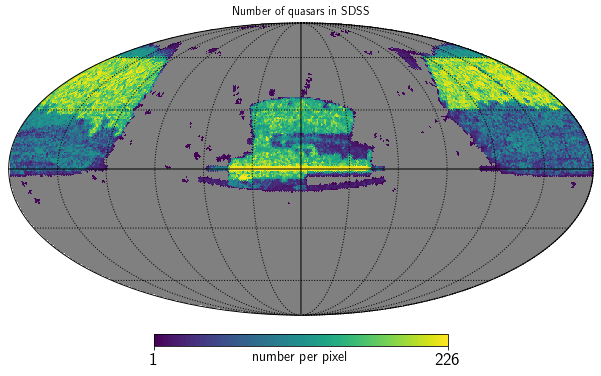

In [94]:
hp.mollview(
    map_nqso_sdss,
    title=r"Number of quasars in SDSS",
    unit=r"number per pixel",
    norm="hist",
    cmap='viridis',
    #coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

In [95]:
map_qso_gaia, pixel_indices_gaia, pixel_indices_grouped_gaia = get_map_nqso(NSIDE, NPIX, tab_gaia['ra'], tab_gaia['dec'])

In [96]:
idx_gaiaINsdss = np.in1d(pixel_indices_gaia, pixel_indices_grouped_sdss)
print(np.sum(idx_gaia_in_sdss)/len(idx_gaia_in_sdss))

0.211603808118978


In [97]:
tab_gaiaINsdss = tab_gaia[idx_gaiaINsdss]

In [99]:
map_qso_gaiaINsdss, pixel_indices_gaiaINsdss, pixel_indices_grouped_gaiaINsdss = get_map_nqso(NSIDE, NPIX,
                                                                                   tab_gaiaINsdss['ra'],
                                                                                   tab_gaiaINsdss['dec'])

0.0 180.0 -180.0 180.0


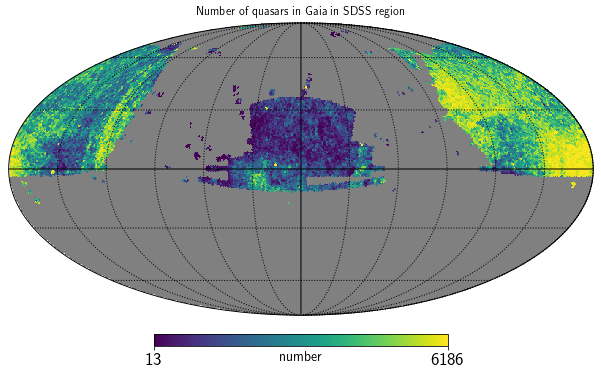

In [100]:
hp.mollview(
    map_qso_gaiaINsdss,
    title=rf"Number of quasars in Gaia in SDSS region",
    unit=r"number",
    norm="hist",
    cmap='viridis',
    #coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

## Now do the cross-match with Gaia-in-SDSS and SDSS

In [56]:
coords_sdss = SkyCoord(ra=tab_sdss['RA']*u.degree, dec=tab_sdss['DEC']*u.degree, frame='icrs')    
coords_gaiaINsdss = SkyCoord(ra=tab_gaiaINsdss['ra'], dec=tab_gaiaINsdss['dec'], frame='icrs') 
cross_sdss_gaiaINsdss = coords_sdss.search_around_sky(coords_gaiaINsdss, 1*u.arcsec) # Hogg thinks this is idiotic

We have some non-unique matches!

In [81]:
unq, unq_idx, unq_count = np.unique(cross_sdss_gaiaINsdss[0], return_inverse=True, return_counts=True)
count_mask = unq_count > 1
dup_ids = unq[count_mask]
print("Number of SDSS objects with multiple Gaia matches:", len(dup_ids))

Number of SDSS objects with multiple Gaia matches: [334395 583663 832725 953070]


In [83]:
unq, unq_idx, unq_count = np.unique(cross_sdss_gaiaINsdss[1], return_inverse=True, return_counts=True)
count_mask = unq_count > 1
dup_ids = unq[count_mask]
print("Number of Gaia objects with multiple SDSS matches:", len(dup_ids))

Number of Gaia objects with multiple SDSS matches: 30


In [71]:
tab_gaiaANDsdss_direct = tab_gaiaINsdss[cross_sdss_gaiaINsdss[0]]
tab_sdssANDgaia_direct = tab_sdss[cross_sdss_gaiaINsdss[1]]
print(len(tab_gaiaANDsdss_direct), len(tab_sdssANDgaia_direct))

407236 407236


In [68]:
# turn list of index numbers into true-false mask
idx_gaiaINsdss_gaiaANDsdss = np.in1d(np.arange(len(tab_gaiaINsdss)), cross_sdss_gaiaINsdss[0])
idx_sdss_gaiaANDsdss = np.in1d(np.arange(len(tab_sdss)), cross_sdss_gaiaINsdss[1])

tab_gaiaANDsdss = tab_gaiaINsdss[idx_gaiaINsdss_gaiaANDsdss]
tab_sdssANDgaia = tab_sdss[idx_sdss_gaiaANDsdss]
print(len(tab_gaiaANDsdss), len(tab_sdssANDgaia))

tab_gaiaNOTsdss = tab_gaiaINsdss[~idx_gaiaINsdss_gaiaANDsdss]
tab_sdssNOTgaia = tab_sdss[~idx_sdss_gaiaANDsdss]
print(len(tab_gaiaNOTsdss), len(tab_sdssNOTgaia))

407232 407205
999756 343192


In [70]:
print(len(tab_gaiaANDsdss)+len(tab_gaiaNOTsdss))
print(len(tab_gaiaINsdss))
print(len(tab_sdssANDgaia)+len(tab_sdssNOTgaia))
print(len(tab_sdss))

1406988
1406988
750397
750397


In [66]:
indices_gaiaINsdss_gaiaANDsdss = np.intersect1d(np.arange(len(tab_gaiaINsdss)), cross_sdss_gaiaINsdss[0])
len(indices_gaiaINsdss_gaiaANDsdss)

407232

In [67]:
indices_sdss_gaiaANDsdss = np.intersect1d(np.arange(len(tab_sdss)), cross_sdss_gaiaINsdss[1])
len(indices_gaiaINsdss_gaiaANDsdss)

407232

In [86]:
print(f'Number of quasars in SDSS: {len(tab_sdss)}')
print(f'Number of quasars in Gaia: {len(tab_gaia)}')
print(f'Number of quasars in Gaia in the SDSS region: {len(tab_gaiaINsdss)}')
print(f'Number of quasars in both Gaia and SDSS: {len(tab_gaiaANDsdss)}')
print(f'Number of quasars in Gaia in SDSS region and not SDSS: {len(tab_gaiaNOTsdss)}')
print(f'Number of quasars in SDSS and not Gaia: {len(tab_sdssNOTgaia)}')

Number of quasars in SDSS: 750397
Number of quasars in Gaia: 6649162
Number of quasars in Gaia in the SDSS region: 1406988
Number of quasars in both Gaia and SDSS: 407232
Number of quasars in Gaia in SDSS region and not SDSS: 999756
Number of quasars in SDSS and not Gaia: 343192


## Investigate them!

In [101]:
map_qso_gaiaNOTsdss, _, _ = get_map_nqso(NSIDE, NPIX, tab_gaiaNOTsdss['ra'], tab_gaiaNOTsdss['dec'])

0.0 180.0 -180.0 180.0


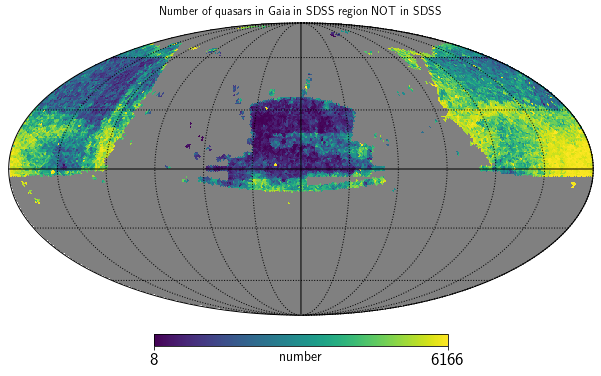

In [104]:
hp.mollview(
    map_qso_gaiaNOTsdss,
    title=rf"Number of quasars in Gaia in SDSS region NOT in SDSS",
    unit=r"number",
    norm="hist",
    cmap='viridis',
    #coord=['C', 'G']
    #min=1,
    #max=1,
)
hp.graticule()

0.0 180.0 -180.0 180.0


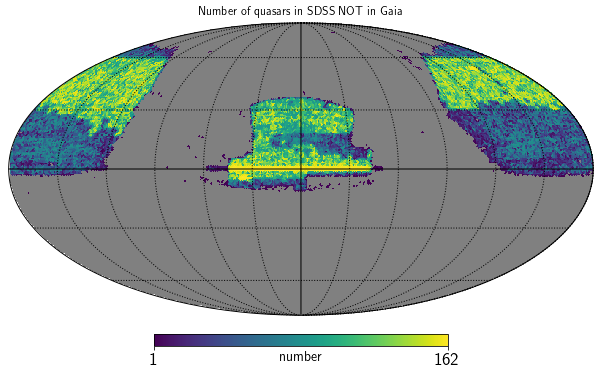

In [105]:
map_qso_sdssNOTgaia, _, _ = get_map_nqso(NSIDE, NPIX, tab_sdssNOTgaia['RA'], tab_sdssNOTgaia['DEC'])

hp.mollview(
    map_qso_sdssNOTgaia,
    title=rf"Number of quasars in SDSS NOT in Gaia",
    unit=r"number",
    norm="hist",
    cmap='viridis',
    #coord=['C', 'G']
    #min=1,
    #max=1,
)
hp.graticule()

In [ ]:
# alpha = 0.75
# lw = 1.5
# density = True
# histtype='step'

# plt.figure(figsize=(8,6))
# _ = plt.hist(Y_train, bins=bins, alpha=alpha, color='g', lw=lw,
#              density=density, histtype=histtype, label=r'$z_{SDSS}$, training')
# _ = plt.hist(Y_hat, bins=bins, alpha=alpha, color='b', lw=lw,
#              density=density, histtype=histtype, label=r'$z_{phot}$, validation')
# _ = plt.hist(Y_hat[sigma_z < 0.1], bins=bins, alpha=alpha, color='m', lw=lw, 
#              density=density, histtype=histtype, label=r'$z_{phot}$, validation ($\sigma_z < 0.1$)')
# plt.xlabel(r'$z$')
# plt.ylabel('density')
# plt.legend()